# Análise da quantidade de itens de um projeto cultural
---

**Objetivo:** realizar uma análise comparativa entre a quantidade de itens de um projeto cultural específico com a quantidade de itens dos outros projetos culturais de um mesmo segmento. Nesta análise, será investigado se a quantidade de itens de um projeto é anormal com relação a quantidade de itens dos outros projetos do mesmo segmento.

#### Importando módulos necessários

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [2]:
df = pd.read_csv('../../data/raw/planilha_orcamentaria.csv')
print(df.columns)
df.head()

Index(['idPronac', 'PRONAC', 'idPlanilhaAprovacao', 'Item', 'idPlanilhaItens',
       'Unidade', 'QtDias', 'QtItem', 'nrOcorrencia', 'VlUnitarioSolicitado',
       'VlTotalSolicitado', 'VlUnitarioAprovado', 'VlTotalAprovado', 'UfItem',
       'MunicipioItem', 'Etapa', 'idArea', 'Area', 'idSegmento', 'Segmento',
       'idProduto', 'Produto', 'DataProjeto', 'cdCidade', 'cdEtapa'],
      dtype='object')


,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,...,Etapa,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto,cdCidade,cdEtapa
0,121051,100855,792860,Passagens Aéreas (Descrever os trechos na tela...,131,Unidade,150,40.0,1.0,150.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,330455,2
1,121051,100855,792883,Bonecos – Criação,3599,Verba,90,1.0,1.0,4000.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,330455,2
2,121051,100855,792903,Produtor executivo,53,Verba,90,3.0,1.0,3000.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,355030,2
3,119968,98671,109095,Assistente de produção,1037,Verba,30,1.0,1.0,1000.0,...,1 - Pré-Produção / Preparação,3,Música,31,Música Popular Cantada,51,Apresentação Musical,2009-12-28 11:37:57.830,330455,1
4,112836,91695,116511,Designer,103,Mês,378,1.0,18.0,2000.0,...,2 - Produção / Execução,7,Artes Integradas,71,Artes Integradas,17,Pesquisa,2009-05-21 10:48:48.790,431490,2


#### Gerando tabela com o número itens por projeto por segmento

In [3]:
num_items = df[['PRONAC', 'idSegmento', 'idPlanilhaAprovacao']].drop_duplicates()
num_items = num_items.groupby(['idSegmento', 'PRONAC']).count()
num_items = num_items.rename(columns={'idPlanilhaAprovacao': 'NumItems'})
num_items.head()

NumItems
idSegmento PRONAC          
11         90105         61
           97310         32
           98022         17
           100855        96
           102857        61

## Análise por segmento
---

Escolheu-se aleatoriamente um segmento para analisar a quantidade de itens dos projetos daquele segmento.

#### Esolhendo um segmento e gerando uma lista do número de itens para todos os projetos do segmento

In [4]:
segment = '11'
segment_projects = num_items.loc[segment]['NumItems']

#### Gerando gráfico dos dados acima

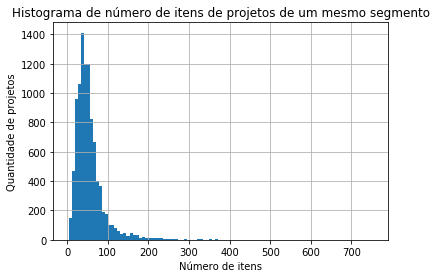

In [5]:
plt.hist(segment_projects, 100)
plt.title('Histograma de número de itens de projetos de um mesmo segmento')
plt.ylabel('Quantidade de projetos')
plt.xlabel('Número de itens')
plt.grid(True)

#### Separando conjunto de treino (70%) e teste (30%)

In [6]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

PRONAC
110602    69
164895    35
150450    72
122651    49
150554    68
Name: NumItems, dtype: int64

PRONAC
119381    12
125135    11
118076    59
150378    28
161851    17
Name: NumItems, dtype: int64

### Análise Gaussiana

In [7]:
import scipy

expected_mean = np.mean(projects_train)
expected_std = np.std(projects_train)
print('Média esperada: %.2lf' % expected_mean)
print('Desvio padrão esperado: %.2lf\n' % expected_std)

k = 1.5
threshold = expected_mean + k * expected_std
expected_perc_outliers = 1 - scipy.stats.norm(expected_mean, expected_std).cdf(threshold)

found_perc_outliers = sum([x > threshold for x in projects_test]) / len(projects_test)

print('Percentual de outliers esperado: %.2lf%%' % (100 * expected_perc_outliers))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * found_perc_outliers))

Média esperada: 55.24
Desvio padrão esperado: 41.49

Percentual de outliers esperado: 6.68%
Percentual de outliers encontrado: 4.97%


### Análise LOF

In [8]:
def to_2D(x):
    ''' Given a pd.Series, return a "2D" np.Array with zeros in one dimension.
    '''
    shape = (len(x),1)
    return np.hstack([np.array(x.tolist()).reshape(shape), np.zeros(shape)])

In [9]:
from sklearn.neighbors import LocalOutlierFactor

# Same expected outliers percentual as gaussian method
contamination = 1 - scipy.stats.norm(0,1).cdf(1.5)

# Work well for LOF
n_neighbors = max(20, int(len(projects_train)/100))

# Convert sets to LOF standard
X_train = to_2D(projects_train)
X_test = to_2D(projects_test)

# Get inliers of the training set with LOF Outlier Detection
lof_OD = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
y_train = lof_OD.fit_predict(X_train)
X_train = X_train[y_train == 1, :]

# Train model with LOF Novelty Detection, using train set inliers
lof_ND = LocalOutlierFactor(novelty=True)
lof_ND = lof_ND.fit(X_train)

# Predict outliers from test set
y_test = lof_ND.predict(X_test)

# Output results
print('Percentual de outliers esperado: %.2lf%%' % (100 * contamination))
print('Percentual de outliers encontrado: %.2lf%%' % (100 * sum(y_test == -1) / len(y_test)))

TypeError: __init__() got an unexpected keyword argument 'novelty'